## Case Study : Ensemble Learning

### Problem Statement:
Predict the cab driver's decision of staying or leaving the company. Also determine the high influence parameters responsible for the employee's churn decision

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns
import warnings

In [2]:
#Ignore warning messages and set grid style for graphs

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [3]:
#Read dataframe

df = pd.read_csv('train.csv')

In [4]:
#Print shape 

df.shape

(19104, 14)

In [5]:
#Glimpse of data

df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [6]:
#Data info - datatypes and null/notnull analysis

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


#### Feature Engineering

In [7]:
#Drop unwanted column

df = df.drop(['Unnamed: 0'], axis=1)

In [8]:
#Make date columns as pandas datetime columns 

df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])

In [9]:
#Re-check the column datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   object        
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

#### Missing values check and treatment

In [10]:
#Check null values

df.isna().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

In [11]:
#KNN imputer
#Apply only to numeric column i.e. Age

imputer = KNNImputer(n_neighbors=5)
df['Age'] = imputer.fit_transform(df['Age'].values.reshape(-1,1))
# df['Gender'] = imputer.fit_transform(df['Gender'].values.reshape(-1,1))

In [12]:
#Fill gender null values with category 3

df['Gender'] = df['Gender'].fillna(3.0)

In [13]:
#Re-check null values

df.isna().sum()

MMM-YY                      0
Driver_ID                   0
Age                         0
Gender                      0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

#### Feature engineering: Aggregrate rows based on driver id

In [14]:
#Aggregate total business value by driver id

df1 = df.groupby(['Driver_ID']).sum()['Total Business Value'].reset_index()

In [15]:
#Get Last row of each driver id report record

df2 = df.groupby(['Driver_ID']).last()['LastWorkingDate'].reset_index()
df2['target'] = df2['LastWorkingDate'].isna()
tar = {False:1, True:0}
df2['target'] = df2['target'].map(tar)

In [16]:
#Prepare column for increased income or not

df3 = df.groupby(['Driver_ID']).first()['Income'].reset_index()
df4 = df.groupby(['Driver_ID']).last()['Income'].reset_index()
df5 = pd.merge(df3,df4,how='inner',on='Driver_ID')
df5['Increased_income'] = df5['Income_y'] > df5['Income_x']
inc = {False:0, True:1}
df5['Increased_income'] = df5['Increased_income'].map(inc)

In [17]:
#Prepare the column for increased rating or not

df6 = df.groupby(['Driver_ID']).first()['Quarterly Rating'].reset_index()
df7 = df.groupby(['Driver_ID']).last()['Quarterly Rating'].reset_index()
df8 = pd.merge(df6,df7,how='inner',on='Driver_ID')
df8['Increased_rating'] = df8['Quarterly Rating_y'] > df8['Quarterly Rating_x']
inc = {False:0, True:1}
df8['Increased_rating'] = df8['Increased_rating'].map(inc)

In [18]:
#Get the columns which do not need aggregration

df9 = df.groupby(['Driver_ID']).first().reset_index()
df9 = df9[['MMM-YY'
        ,'Driver_ID'
        ,'Age'
        ,'Gender'
        ,'City'
        ,'Education_Level'
        ,'Dateofjoining'
        ,'Joining Designation'
        ,'Grade']]

In [19]:
#Get shape of all dfs

df2.shape, df5.shape, df8.shape, df9.shape

((2381, 3), (2381, 4), (2381, 4), (2381, 9))

In [20]:
#Merge dfs based on driver id

final_df1 = pd.merge(df2,df5
                    ,how='inner'
                    ,on='Driver_ID')

final_df2 = pd.merge(df8,df9
                    ,how='inner'
                    ,on='Driver_ID')

final_df = pd.merge(final_df1,final_df2
                    ,how='inner'
                    ,on='Driver_ID')

In [21]:
#Drop unwanted columns

final_df = final_df.drop(['LastWorkingDate'
                          ,'Income_x'
                          ,'Income_y'
                          ,'Quarterly Rating_x'
                          ,'Quarterly Rating_y'
                          ,'MMM-YY'
                          ] ,axis=1)

In [22]:
# final_df.rename(columns={'MMM-YY':'Reporting_Date'},inplace=True)
# final_df['Reporting_Year'] = final_df['Reporting_Date'].dt.year
# final_df['Reporting_Month'] = final_df['Reporting_Date'].dt.month

In [23]:
#Separate out year and month of joining date

final_df['Dateofjoining_Year'] = final_df['Dateofjoining'].dt.year
final_df['Dateofjoining_Month'] = final_df['Dateofjoining'].dt.month

In [24]:
#Get final df shape

final_df.shape

(2381, 13)

In [25]:
#Rearrange the columns

final_df = final_df[['Driver_ID'
                     ,'Dateofjoining'
                     ,'Dateofjoining_Year'
                     ,'Dateofjoining_Month'
                     ,'Age'
                     ,'Gender'
                     ,'City'
                     ,'Education_Level'
                     ,'Joining Designation'
                     ,'Grade'
                     ,'Increased_income'
                     ,'Increased_rating'
                     ,'target']]

In [26]:
#Get glimpse of final df

final_df.head()

,Driver_ID,Dateofjoining,Dateofjoining_Year,Dateofjoining_Month,Age,Gender,City,Education_Level,Joining Designation,Grade,Increased_income,Increased_rating,target
0,1,2018-12-24,2018,12,28.0,0.0,C23,2,1,1,0,0,1
1,2,2020-11-06,2020,11,31.0,0.0,C7,2,2,2,0,0,0
2,4,2019-12-07,2019,12,43.0,0.0,C13,2,2,2,0,0,1
3,5,2019-01-09,2019,1,29.0,0.0,C9,0,1,1,0,0,1
4,6,2020-07-31,2020,7,31.0,1.0,C11,1,3,3,0,1,0


#### Statistics

In [27]:
#Get statistical details of final df

final_df.describe()

,Driver_ID,Dateofjoining_Year,Dateofjoining_Month,Age,Gender,Education_Level,Joining Designation,Grade,Increased_income,Increased_rating,target
count,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,1397.559009,2018.536329,7.357413,33.110184,0.417052,1.00756,1.820244,2.078538,0.018060,0.150357,0.678706
std,806.161628,1.609597,3.143143,5.833198,0.508279,0.81629,0.841433,0.931321,0.133195,0.357496,0.467071
min,1.000000,2013.000000,1.000000,21.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,695.000000,2018.000000,5.000000,29.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1400.000000,2019.000000,7.000000,33.000000,0.000000,1.00000,2.000000,2.000000,0.000000,0.000000,1.000000
75%,2100.000000,2020.000000,10.000000,37.000000,1.000000,2.00000,2.000000,3.000000,0.000000,0.000000,1.000000
max,2788.000000,2020.000000,12.000000,58.000000,3.000000,2.00000,5.000000,5.000000,1.000000,1.000000,1.000000


#### Correlation

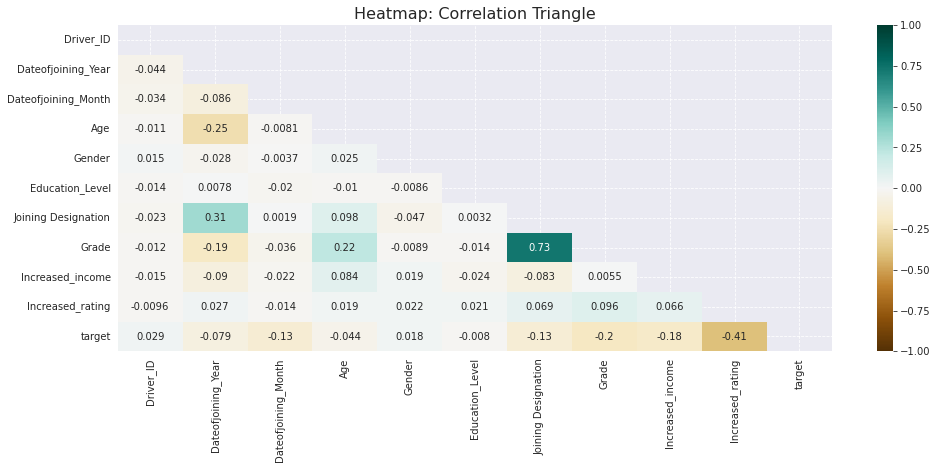

In [28]:
#Plot correlation

corr = final_df.corr()

plt.figure(figsize=(16,6))
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('Heatmap: Correlation Triangle',fontdict={'fontsize':16})
plt.grid(linestyle='--')
plt.show()

#### Univariate and bivariate analysis

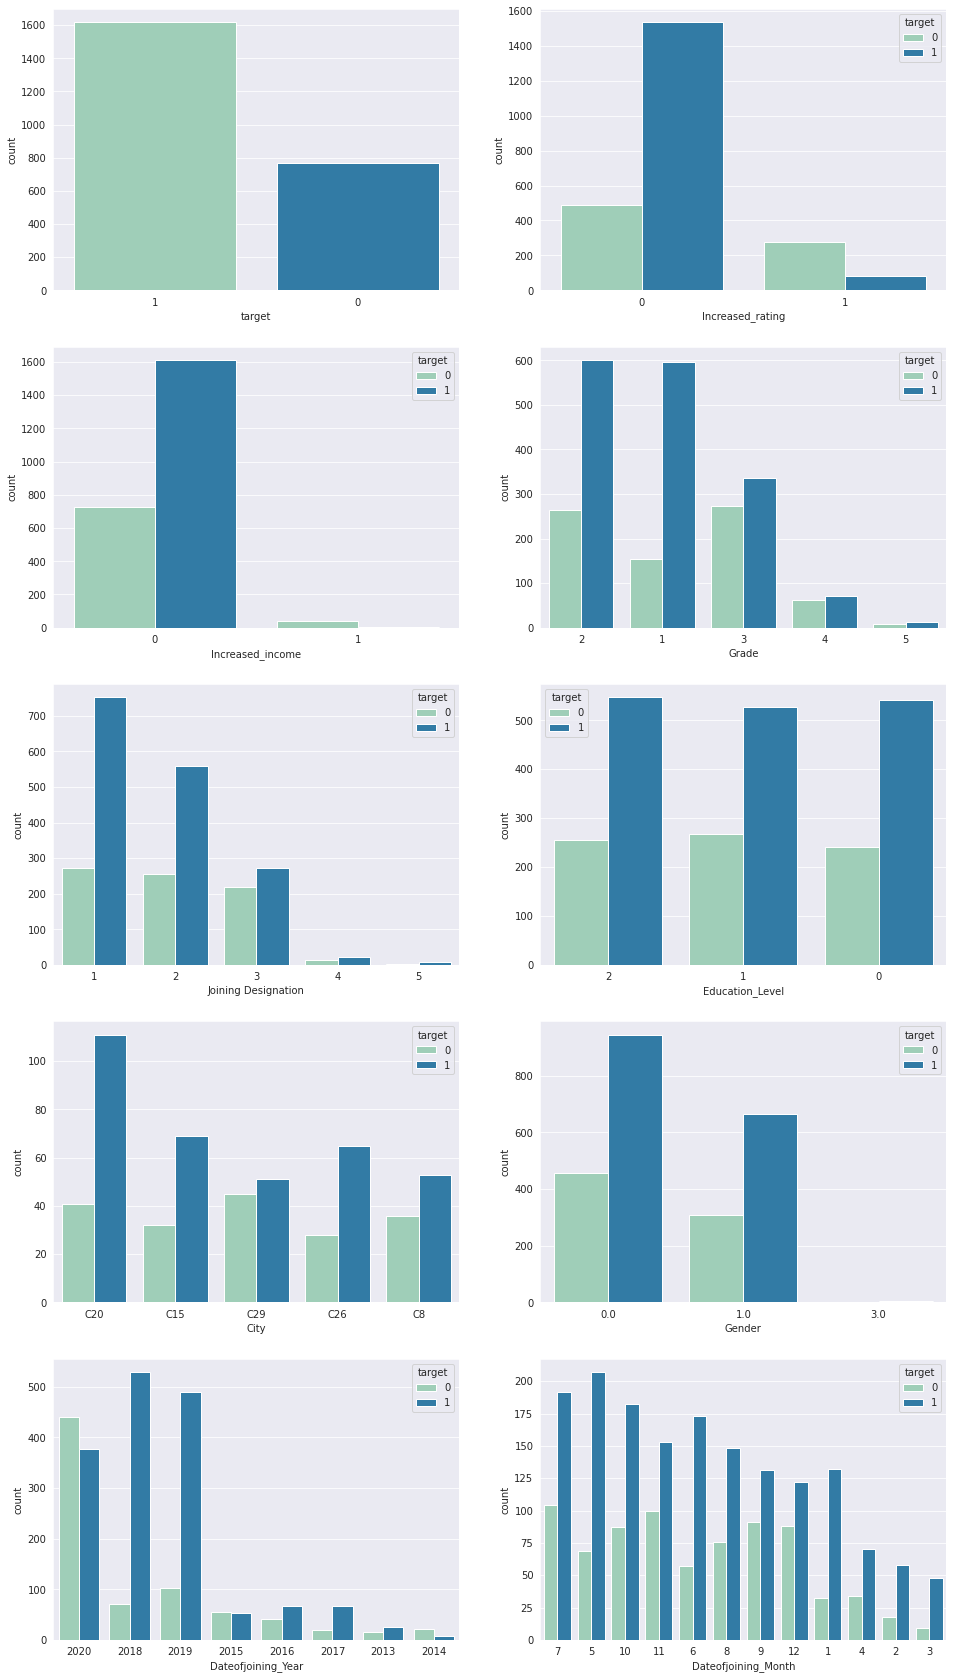

In [29]:
#Countplots for categorical variables w.r.t. target variable

fig,axes = plt.subplots(5,2,figsize=(16,30))
sns.countplot(final_df['target'],ax=axes[0,0]
              ,order=final_df['target'].value_counts().index
              ,palette='YlGnBu')
sns.countplot(final_df['Increased_rating'],hue=final_df['target'],ax=axes[0,1]
              ,order=final_df['Increased_rating'].value_counts().index
              ,palette='YlGnBu')
sns.countplot(final_df['Increased_income'],hue=final_df['target'],ax=axes[1,0]
              ,order=final_df['Increased_income'].value_counts().index
              ,palette='YlGnBu')
sns.countplot(final_df['Grade'],hue=final_df['target'],ax=axes[1,1]
              ,order=final_df['Grade'].value_counts().index
              ,palette='YlGnBu')
sns.countplot(final_df['Joining Designation'],hue=final_df['target'],ax=axes[2,0]
              ,order=final_df['Joining Designation'].value_counts().index
              ,palette='YlGnBu')
sns.countplot(final_df['Education_Level'],hue=final_df['target'],ax=axes[2,1]
              ,order=final_df['Education_Level'].value_counts().index
              ,palette='YlGnBu')
sns.countplot(final_df['City'],hue=final_df['target'],ax=axes[3,0]
              ,order=final_df['City'].value_counts().index[:5]
              ,palette='YlGnBu')
sns.countplot(final_df['Gender'],hue=final_df['target'],ax=axes[3,1]
              ,order=final_df['Gender'].value_counts().index
              ,palette='YlGnBu')
sns.countplot(final_df['Dateofjoining_Year'],hue=final_df['target'],ax=axes[4,0]
              ,order=final_df['Dateofjoining_Year'].value_counts().index
              ,palette='YlGnBu')
sns.countplot(final_df['Dateofjoining_Month'],hue=final_df['target'],ax=axes[4,1]
              ,order=final_df['Dateofjoining_Month'].value_counts().index
              ,palette='YlGnBu')

plt.show()

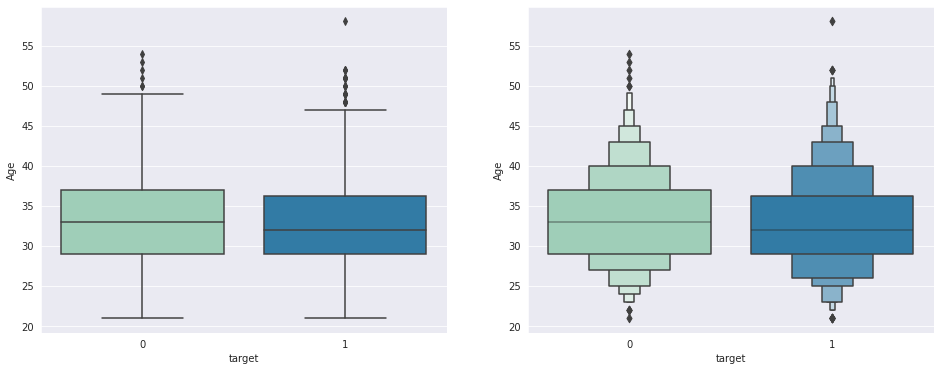

In [30]:
#Box plot for cont. variable w.r.t. target variable

fig,axes = plt.subplots(1,2,figsize=(16,6))
sns.boxplot(data=final_df, y='Age', x='target', ax=axes[0],palette='YlGnBu')
sns.boxenplot(data=final_df, y='Age', x='target',ax=axes[1],palette='YlGnBu')
plt.show()

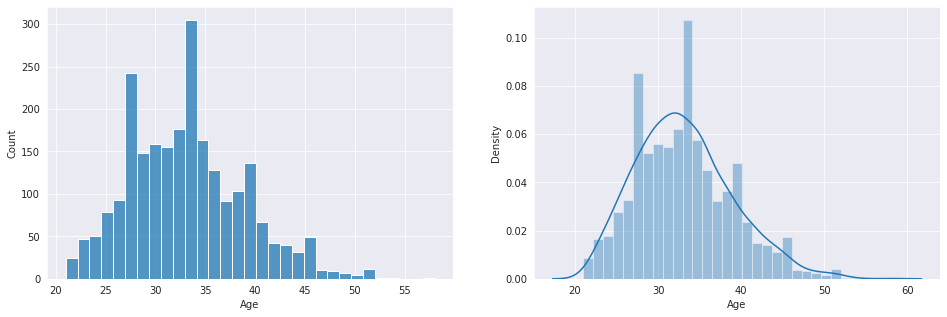

In [31]:
#Plot distribution of cont. variable 

fig,axes = plt.subplots(1,2,figsize=(16,5))
sns.histplot(final_df['Age'], ax=axes[0])
sns.distplot(final_df['Age'], ax=axes[1])
plt.show()

#### Prepare data for model building

In [32]:
#Drop unwanted columns

df_ml = final_df.drop(['Driver_ID'
                       ,'Dateofjoining'
                       ,'Dateofjoining_Year'
                       ,'Dateofjoining_Month'], axis=1)

In [33]:
#import libraries 

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#### OneHotEncoding

In [34]:
#Perform one hot encoding for City column

df_ml = pd.get_dummies(df_ml,prefix=[''],columns=['City'])

In [35]:
#Check for data imbalance on target variable

data_imbalance = pd.DataFrame()
data_imbalance['Category'] = df_ml['target'].value_counts().index
data_imbalance['Value_Counts'] = df_ml['target'].value_counts().values
data_imbalance['Percentage'] = 100*data_imbalance['Value_Counts']/sum(data_imbalance['Value_Counts'])
data_imbalance['Percentage'] = round(data_imbalance['Percentage'],2)

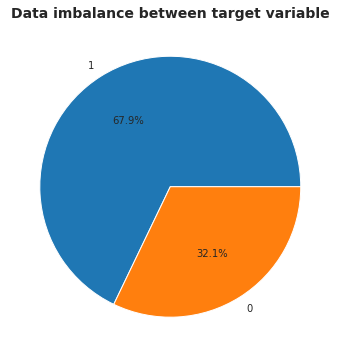

In [36]:
#Plot data imbalance

plt.figure(figsize=(6,6))
plt.pie(data_imbalance['Value_Counts']
        ,labels=data_imbalance['Category']
        ,autopct='%1.1f%%')
plt.title('Data imbalance between target variable',fontdict={'weight':'bold'
                                                             ,'size':14})
plt.show()

In [37]:
#Get input and output variables

X = df_ml.drop(['target'], axis=1)
y = df_ml['target']

In [38]:
#Split train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [39]:
#Shape of train and test data

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1904, 36), (477, 36), (1904,), (477,))

In [40]:
#target train value counts

y_train.value_counts()

1    1288
0     616
Name: target, dtype: int64

#### Class imbalance treatement

In [41]:
#Smote to balance the classes

smt = SMOTE()
X_sm, y_sm = smt.fit_resample(X_train, y_train)

In [42]:
#Get shape of balanced data

X_sm.shape, y_sm.shape

((2576, 36), (2576,))

In [43]:
#Shape of balanced target train variable

y_sm.value_counts()

1    1288
0    1288
Name: target, dtype: int64

#### Model Building

In [44]:
#Import libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.ensemble import GradientBoostingClassifier as GBC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

#### Bagging

#### RandomForestClassifier without hyperparameter tuning

In [45]:
#Create RandomForestClassifier model

rfc = RandomForestClassifier(random_state=42
                             ,max_depth=4
                             ,n_estimators=100)
kfold = KFold(n_splits=10)

cv_acc_results = cross_validate(rfc
                                ,X_sm
                                ,y_sm
                                ,cv=kfold
                                ,scoring='accuracy'
                                ,return_train_score=True)

print(f"K-Fold Accuracy Mean: Train: {round(cv_acc_results['train_score'].mean()*100,4)} | Validation: {round(cv_acc_results['test_score'].mean()*100,4)}")
print(f"K-Fold Accuracy Std: Train : {round(cv_acc_results['train_score'].std()*100,4)}  | Validation: {round(cv_acc_results['test_score'].std()*100,4)}")

K-Fold Accuracy Mean: Train: 68.8059 | Validation: 63.8416
K-Fold Accuracy Std: Train : 1.4447  | Validation: 12.8957


#### RandomForestClassifier with hyperparameter tuning : Gridsearch

In [46]:
#Do hyperparameter tuning using GridSearchCV

params = {
          'n_estimators' : [100,200,300,400],
          'max_depth' : [10,12,14,16],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False]
#          'max_features' : [8,9,10,11,12]
         }

tuning_function = GridSearchCV(estimator = RandomForestClassifier(random_state=42), 
                               param_grid = params,
                               scoring = 'accuracy',
                               cv = 3,
                               n_jobs=-1
                               )

In [47]:
#Train and validate on hypermaters

tuning_function.fit(X_sm, y_sm)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 12, 14, 16],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [48]:
#Print the best parameters and corresponding best score on validation set

print('Best parameters: ', tuning_function.best_params_)
print('Best score: ', tuning_function.best_score_)

Best parameters:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 200}
Best score:  0.720879431007487


In [67]:
#Build RandomForestClassifier with best parameters provided by Gridsearch

rfc = RandomForestClassifier(random_state=42
                             ,bootstrap=True
                             ,criterion='entropy'
                             ,max_depth=12
#                             ,max_features=18
                             ,n_estimators=200)
kfold = KFold(n_splits=12)

cv_acc_results = cross_validate(rfc
                                ,X_sm
                                ,y_sm
                                ,cv=kfold
                                ,scoring='accuracy'
                                ,return_train_score=True)

print(f"K-Fold Accuracy Mean: Train: {round(cv_acc_results['train_score'].mean()*100,4)} | Validation: {round(cv_acc_results['test_score'].mean()*100,4)}")
print(f"K-Fold Accuracy Std: Train : {round(cv_acc_results['train_score'].std()*100,4)}  | Validation: {round(cv_acc_results['test_score'].std()*100,4)}")

K-Fold Accuracy Mean: Train: 80.3714 | Validation: 68.8573
K-Fold Accuracy Std: Train : 0.9171  | Validation: 6.5763


In [53]:
#Fit the RandomForestClassifier
#Print important features

rfc.fit(X_sm,y_sm)

print(f"Training accuracy:{round(rfc.score(X_sm, y_sm),4)}")
print(f"Test Accuracy    :{round(rfc.score(X_test, y_test),4)}")
print(rfc.feature_importances_)

Training accuracy:0.9457
Test Accuracy    :0.696
[0.22918694 0.07810704 0.07544996 0.05365633 0.07331415 0.01715353
 0.13059701 0.00862197 0.01272221 0.00882124 0.01244322 0.0155677
 0.01711444 0.01344899 0.01086591 0.01214762 0.00601138 0.00738541
 0.01243495 0.02165529 0.00590394 0.01178224 0.01592012 0.01263469
 0.01076769 0.01252951 0.01366842 0.01224342 0.01085654 0.01126475
 0.0109189  0.00729647 0.01313242 0.01188248 0.01185032 0.01064281]


#### RandomForestClassifier with hyperparameter tuning using RandomizedSearch

In [92]:
#Prepare Randomized Search model for hyperparameter tuning

params = {'ccp_alpha': uniform(loc=0, scale=1)}

tuning_function = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42
                                                                      ,bootstrap=False
                                                                      ,criterion='gini'
                                                                      ,max_depth=10
 #                                                                     ,max_features=18
                                                                      ,n_estimators=200), 
                               param_distributions = params,
                               scoring = 'accuracy',
                               cv = 5,
                               n_iter=15,
                               n_jobs=-1
                               )

In [93]:
#fit the model

tuning_function.fit(X_sm, y_sm)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(bootstrap=False,
                                                    max_depth=10,
                                                    n_estimators=200,
                                                    random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4c956479d0>},
                   scoring='accuracy')

In [94]:
#Print best params and best score

print('Best parameters: ', tuning_function.best_params_)
print('Best score: ', tuning_function.best_score_)

Best parameters:  {'ccp_alpha': 0.02729354605963863}
Best score:  0.6176059306088657


#### Bootstrap

#### GBDT without hyperparameter tuning

In [96]:
#Prepare gbc model

gbc = GBC(n_estimators=200
          ,learning_rate=0.2
          ,max_depth=4
          ,random_state=42
          ,verbose = 1)

#Fit gbc model

gbc.fit(X_sm, y_sm)

      Iter       Train Loss   Remaining Time 
         1           1.3273            1.28s
         2           1.2865            1.16s
         3           1.2569            1.11s
         4           1.2333            1.08s
         5           1.2151            1.04s
         6           1.2000            1.03s
         7           1.1864            1.03s
         8           1.1762            1.03s
         9           1.1664            1.01s
        10           1.1568            1.00s
        20           1.0685            0.97s
        30           0.9990            0.83s
        40           0.9490            0.71s
        50           0.9021            0.62s
        60           0.8611            0.58s
        70           0.8256            0.52s
        80           0.7936            0.46s
        90           0.7658            0.41s
       100           0.7347            0.37s
       200           0.5474            0.00s


GradientBoostingClassifier(learning_rate=0.2, max_depth=4, n_estimators=200,
                           random_state=42, verbose=1)

In [97]:
#Print accuracy score for train and test
#Print feature weights

print(f"Training accuracy:{round(gbc.score(X_sm, y_sm),2)}")
print(f"Test Accuracy    :{round(gbc.score(X_test, y_test),2)}")
print(gbc.feature_importances_)

Training accuracy:0.92
Test Accuracy    :0.71
[0.18522292 0.07722277 0.05392806 0.04476595 0.10898599 0.01755096
 0.17152876 0.00889285 0.01142708 0.0093885  0.01089527 0.01562974
 0.01766037 0.01459877 0.01040805 0.01261493 0.00630642 0.0068488
 0.01257215 0.02461897 0.00684319 0.00933408 0.01827236 0.01240702
 0.01116424 0.01468411 0.01350518 0.01264791 0.00959517 0.00978925
 0.01034652 0.00612116 0.01374504 0.01111666 0.01035115 0.00900964]


#### GBDT using hyperparameter tuning

In [98]:
#Prepare xgboost model 

params = {
        'learning_rate': [0.1, 0.2, 0.5, 0.8],
#        'subsample': [0.4, 0.6, 0.8, 1.0],
#        'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
        }
xgb = XGBClassifier(n_estimators=300
#                    , objective='multi:softmax'
#                    , num_class=20
                    , silent=True)

In [99]:
#Perform randomsized search technique to get the best parameters

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb
                                   ,param_distributions=params
                                   ,n_iter=10
                                   ,scoring='accuracy'
                                   ,n_jobs=4
                                   ,cv=skf.split(X_sm,y_sm)
                                   ,verbose=3
                                   ,random_state=42 )

In [100]:
#Fit the model

random_search.fit(X_sm, y_sm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[18:18:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f4c955a04a0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=300, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.5, 0.8],
                                        'max_depth': [3, 4, 5, 6]},
                   random_state=42, scoring='accuracy', verbose=3)

In [101]:
#Print best params

random_search.best_params_

{'max_depth': 4, 'learning_rate': 0.5}

In [102]:
#Prepare xgboost model using best parameters

best_xgb = XGBClassifier(n_estimators=300
#                         ,objective='multi:softmax'
#                         ,num_class=20
#                         ,subsample=0.6
                         ,max_depth=4
                         ,learning_rate=0.5
#                         ,colsample_bytree=0.4
                         ,silent=True)
#fit the model

best_xgb.fit(X_sm, y_sm)

[18:18:56] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [103]:
#Print train and test accuracy on xgboost

print(f"Training accuracy:{round(best_xgb.score(X_sm, y_sm),2)}")
print(f"Test Accuracy    :{round(best_xgb.score(X_test, y_test),2)}")
print(best_xgb.feature_importances_)

Training accuracy:0.94
Test Accuracy    :0.7
[0.01229063 0.02353914 0.01300833 0.01563607 0.02224434 0.06264051
 0.11356995 0.02080983 0.02382904 0.0235223  0.02125725 0.03504054
 0.03901531 0.02876423 0.02200101 0.02494406 0.0194694  0.02128033
 0.02595642 0.0324132  0.02073774 0.02195585 0.03629418 0.02684841
 0.02735407 0.0272454  0.02981721 0.02651545 0.02129011 0.02211406
 0.02691846 0.0152661  0.02994184 0.0218766  0.02295459 0.02163815]


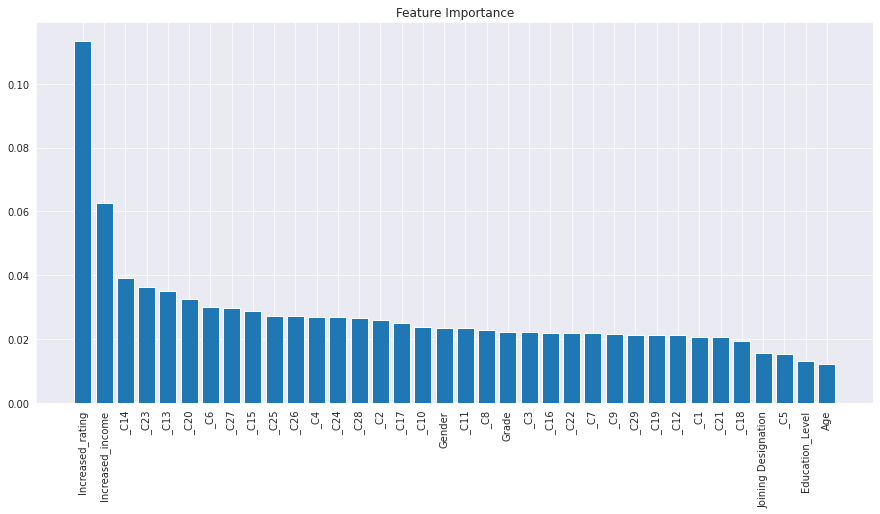

In [104]:
#Plot the important features in descending order

importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1] 
names = [X_sm.columns[i] for i in indices]
plt.figure(figsize=(15, 7)) 
plt.title("Feature Importance") 
plt.bar(range(X_sm.shape[1]), importances[indices]) 
plt.xticks(range(X_sm.shape[1]), names, rotation=90) 
plt.show() 

#### ROC AUC Curve and Classification Report

In [105]:
#Import libraries

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

In [106]:
#Predict y values of target

y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)

In [107]:
#Print classification report/metrics

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.53      0.47      0.50       149
           1       0.77      0.81      0.79       328

    accuracy                           0.70       477
   macro avg       0.65      0.64      0.64       477
weighted avg       0.70      0.70      0.70       477



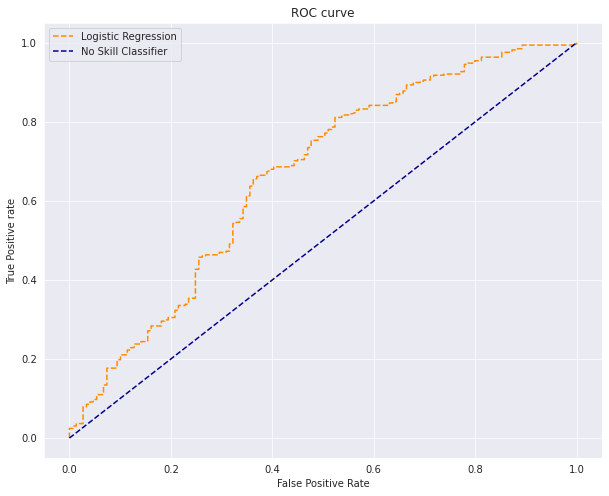

In [108]:
#Roc Curve
random_probs = [0 for i in range(len(y_test))]

p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

fpr, tpr, thresh = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, linestyle='--',color='darkorange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='darkblue', label='No Skill Classifier')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

In [109]:
#Get ROC AUC score

roc_auc_score(y_test, y_pred_proba[:,1]).round(2)

0.66

#### Confusion Matrix

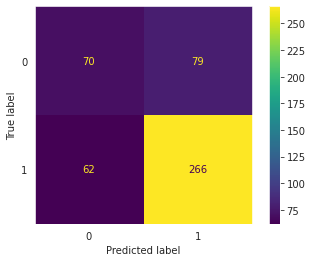

In [110]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.grid()
plt.show()

#### Note

1. The model accuracy is 0.71
2. ROC Auc score shows that there is a scope for improvement of model accuracy
3. Need to peform better hyperparameter tuning
4. Hyperparameter tunning will need more time. So currently submitting the case study with reasonable model and not the best one

#### Observations & Recommendations

Observations:

1. The most important parameters to predict Churn are ratings and income
2. Driver's have left if there has been no increase in income and ratings
3. Most of the people that have left are with Grade 2 and 1
4. Most of the people that have left are from cities C20 and C15
5. Most of the people that have left are with the designation 1 and 2

Recommendations:
1. Please consider providing market compatible incentives to the employees
2. Consider the city allowances based on cities standards of living
3. Rating is one of most influential factor, so please consider ways to keep driver's motivated
